In [1]:
from pathlib import Path
import os
from os import listdir
from os.path import isfile, join
from scipy.io.wavfile import read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt, exp
import scipy
import librosa
import librosa.display
plt.style.use('seaborn-poster')
%matplotlib inline
from sklearn.linear_model import LinearRegression
from scipy import signal
from tqdm import tqdm
from scipy.signal import find_peaks

In [2]:
root_dir = Path(os.getcwd())
wav_path = root_dir/'wav_database'
sample_rate = 16000

In [141]:
sample_word = 'on'

In [142]:
wav_samples = [wav_path/sample_word/f for f in listdir(wav_path/sample_word) if isfile(join(wav_path/sample_word, f))]
print(len(wav_samples))

700


speechcommands data is sampled at 16 kHz -> 62.5 us. Total length of audio recording is 1s.

Original Praat shape of broadband -> 256 x 991, narrowband -> 512 x 445

Compute short-term spectral analysis: Compute a spectrum of a discrete set of time points in the audio signal.

Spectrogram Parameters:
- Window Length (s): (broadband: 0.005, narrowband: 0.03) Duration of analysis window, affects bandwidth of signal.
    - Given 62.5 us between each sample, to get a 0.005 s window, we take 80 samples. For 0.03 s window -> 480 samples.
- Max Freq (Hz): (broadband & narrowband: 8000 kHz) Highest frequency we want to see. Don't make this more than 2x sample frequency.
- Time Step (s): (broadband & narrowband: 0.01 s) 
    - For a time step of 0.001 s, we move forward by 16 samples per window.
- Frequency Step (Hz): (broadband & narrowband: 20 Hz) 

Formant Acquisition Parameters:
- Time Step (s): (25% of window length)
- Number of Formants: usually 5
- Formant Ceiling (Hz): 6000. Usually 5000-5500 for adults, and can be up to 8000 for children.
- Window Length (s): (0.025) 400 samples
- Preemphasis: (P = 30 Hz). This fits the equation: e^(-2 * pi * P * 6.25e-5), where 6.25e-5 is the sampling period of the sound (1/16000) and P = 30, giving us around 98%, close to a typical value.

# Utility Functions

In [143]:
def DFT(x):
    """
    x: 1D real-valued signal as a list
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

# Make Formants
Courtesy of https://sail.usc.edu/~lgoldste/Ling582/Week%209/LPC%20Analysis.pdf

In [144]:
def pre_emphasize(signal, pre_emph_factor):
    # Perform pre-emphasis
    pre_emph_wav = []
    for i in range(len(signal)-1):
        pre_emph_wav.append(signal[i+1] - pre_emph_factor*signal[i])
    pre_emph_wav = np.array(pre_emph_wav)
    return pre_emph_wav

In [145]:
def lpc_coef(signal, window_size, M, ibeg):
    iend = ibeg + window_size # iend is the last sample in the window
    Y = signal[ibeg:iend] # Take window_size data points from signal
    if not len(Y) == window_size:
        Y = np.concatenate([Y, [0]*(window_size-len(Y))])
#         Y = Y * np.hamming(window_size)

    # X is a (M x window_size) matrix
    X = []
    for i in range(1,M):
        ibeg_delay = (ibeg - i) if (ibeg - i >= 0) else 0
        iend_delay = (iend - i) if (iend - i >= 0) else 0
        signal_delay = signal[ibeg_delay:iend_delay]
        X.append(np.concatenate([[0]*(window_size-len(signal_delay)), signal_delay]))
    X = np.array(X).T

    acoef = LinearRegression().fit(X, Y).coef_
    acoef = np.concatenate([np.array([1]), -acoef])

    return acoef

In [146]:
def lpc_fft(acoef, num_fft_points, pad):
    acoef_padded = np.concatenate([np.array(acoef), np.array([0]*(num_fft_points-len(acoef)))])
    num = 1
    if (pad):
        den = acoef
    else:
        den = acoef_padded
    transfer = scipy.signal.freqz(num, den)
    lpc = np.log(abs(transfer[1]))
    lpcf = transfer[0]

    return lpcf, lpc

In [147]:
def lpc_wgdf(acoef, num_fft_points):
    acoef_padded = np.concatenate([np.array(acoef), np.array([0]*(num_fft_points-len(acoef)))])
    
    fftx = DFT(acoef_padded)
    fftnx = DFT(acoef_padded * np.arange(len(acoef_padded)))
    
    fftx_real = fftx.real
    fftx_imag = fftx.imag
    fftnx_real = fftnx.real
    fftnx_imag = fftnx.imag
    
    abs_fftx = abs(fftx)
    
    wgdf = []
    
    for i in range(len(abs_fftx) // 2):
        num = fftx_real[i]*fftnx_real[i] + fftx_imag[i]*fftnx_imag[i]
        exp = 0.4/num_fft_points * i + 0.8
        den = np.power(abs_fftx[i], exp)
        wgdf.append(den)

    return np.array(wgdf)

In [148]:
def lpc(signal, window_size, M, num_fft_points, pad=False):
    """
    Calculate LPC coefficients, then do FFT on the coefficients to get formant profile of spectrogram.
    
    To plot lpc_diagram:
        plt.imshow(lpc_diagram, extent=[0, 20000, 0, 8000])
        plt.xlabel("couple hundreds of seconds")
        plt.ylabel("Hz")
    
    To plot lpc_history of one spectrum (eg. sample 30):
        plt.plot(lpcf*sample_rate/(2*np.pi), lpc_history[30])
    """
    time_step = 0.25 * window_size
    
    lpc_history = []
    wgdf_history = []
    acoef_history = []
    for ibeg in range(0, len(signal), int(time_step)):
        acoef = lpc_coef(signal, window_size, M, ibeg)
        lpcf, lpc = lpc_fft(acoef, num_fft_points, pad)
        wgdf = lpc_wgdf(acoef, num_fft_points)
        lpc_history.append(lpc)
        wgdf_history.append(wgdf)
        acoef_history.append(acoef)

    lpc_diagram = np.vstack(lpc_history)
    lpc_diagram = list(map(list, zip(*lpc_diagram)))[::-1]
    wgdf_diagram = np.vstack(wgdf_history)
    wgdf_diagram = list(map(list, zip(*wgdf_diagram)))[::-1]
    
    return acoef_history, lpc_history, lpcf, lpc_diagram, wgdf_history, wgdf_diagram

In [149]:
def formants(lpc_history, lpcf):
    """
    Normally we would find the derivative, and find zero-crossings where the derivative goes from pos->neg.
    However, some of the tiny peaks in the lpc curve don't actually cross 0, but close to 0.
    So we will document not just 0 crossings, but also crossings across a range slightly larger than 0, eg. [-4,4].
    Then, we will get discrete ranges of x-axis values in the lpc curve where we keep seeing crossings.
    For each discrete range, we will determine the formant as the middle of the discrete range.
    """
    formant_history = []
    crosses_between_range_history = []
    
    for i in range(len(lpc_history)):
        crosses_between_range = [False]*len(lpc_history[i]) # range set is [-4,4]
        
        dx = np.gradient(lpc_history[i])*100
        for j in range(len(dx)):
            if (j == 0):
                prev_dx = dx[j]
                next_dx = dx[j+1]
            elif (j == len(dx)-1):
                prev_dx = dx[j-1]
                next_dx = dx[j]
            else:
                prev_dx = dx[j-1]
                next_dx = dx[j+1]
            
            crosses_between_range[j] = (prev_dx > next_dx) and \
                                   (((prev_dx < 4 and prev_dx > -4) and (next_dx < 4 and next_dx > -4)) or \
                                    ((prev_dx > 4) and (next_dx < 4 and next_dx > -4)) or \
                                    ((prev_dx < 4 and prev_dx > -4) and (next_dx < -4)) or \
                                    ((prev_dx > 4) and (next_dx < -4)))
            
        crosses_between_range_history.append(crosses_between_range)
        
        formants = []
        seen_start = False
        for k in range(len(crosses_between_range)-1):
            if crosses_between_range[k] and not seen_start:
                seen_start = True
                start = k
            elif not crosses_between_range[k] and seen_start:
                seen_start = False
                stop = k
                if (stop - start % 2 == 0): # if this is even, you saw an odd number of True
                    start += 1 # median interpolates if even no. of True. We don't want interpolation, so drop the first True
                formants.append(lpcf[int(np.median([start, stop]))]*sample_rate/(2*np.pi))
            
        formants = np.array(formants)
        if (len(formants) < 5):
            formants = np.concatenate([formants, np.array([0]*(5-len(formants)))])
        elif (len(formants) > 5):
            formants = formants[0:5]
            
        formant_history.append(formants)
        
    return crosses_between_range_history, np.array(formant_history).T

In [150]:
def normalize(spectrogram):
    min_val = min(map(min, spectrogram))
    max_val = max(map(max, spectrogram))
    
    if not type(spectrogram).__module__ == np.__name__:
        spectrogram = np.array(spectrogram)

    normed = np.array([[0]*spectrogram.shape[1]]*spectrogram.shape[0], dtype='float64')
    for i in range(spectrogram.shape[0]):
        newval = (spectrogram[i] - min_val) / (max_val - min_val)
        normed[i] = (spectrogram[i] - min_val) / (max_val - min_val)
        
    return normed

In [193]:
curr_wav = wav_samples[14]
curr_wav = read(curr_wav)[1]
acoef_history, lpc_history, lpcf, lpc_diagram, wgdf_history, wgdf_diagram = lpc(pre_emphasize(curr_wav, 0.98), window_size=400, M=12, num_fft_points=256, pad=True)
crosses_between_range_history, formant_history = formants(lpc_history, lpcf)

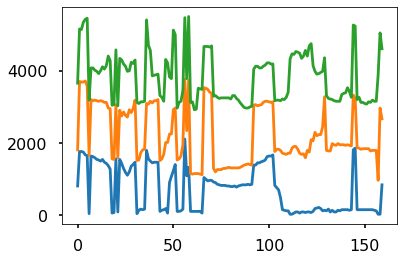

In [194]:
for i in range(0,3):
    plt.plot(formant_history[i])

Text(0, 0.5, 'Hz')

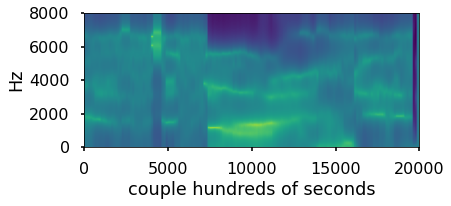

In [195]:
plt.imshow(lpc_diagram, extent=[0, 20000, 0, 8000])
plt.xlabel("couple hundreds of seconds")
plt.ylabel("Hz")

Obtaining Formants...: 100%|███████████████████████████████████████████████████████████| 20/20 [03:04<00:00,  9.24s/it]


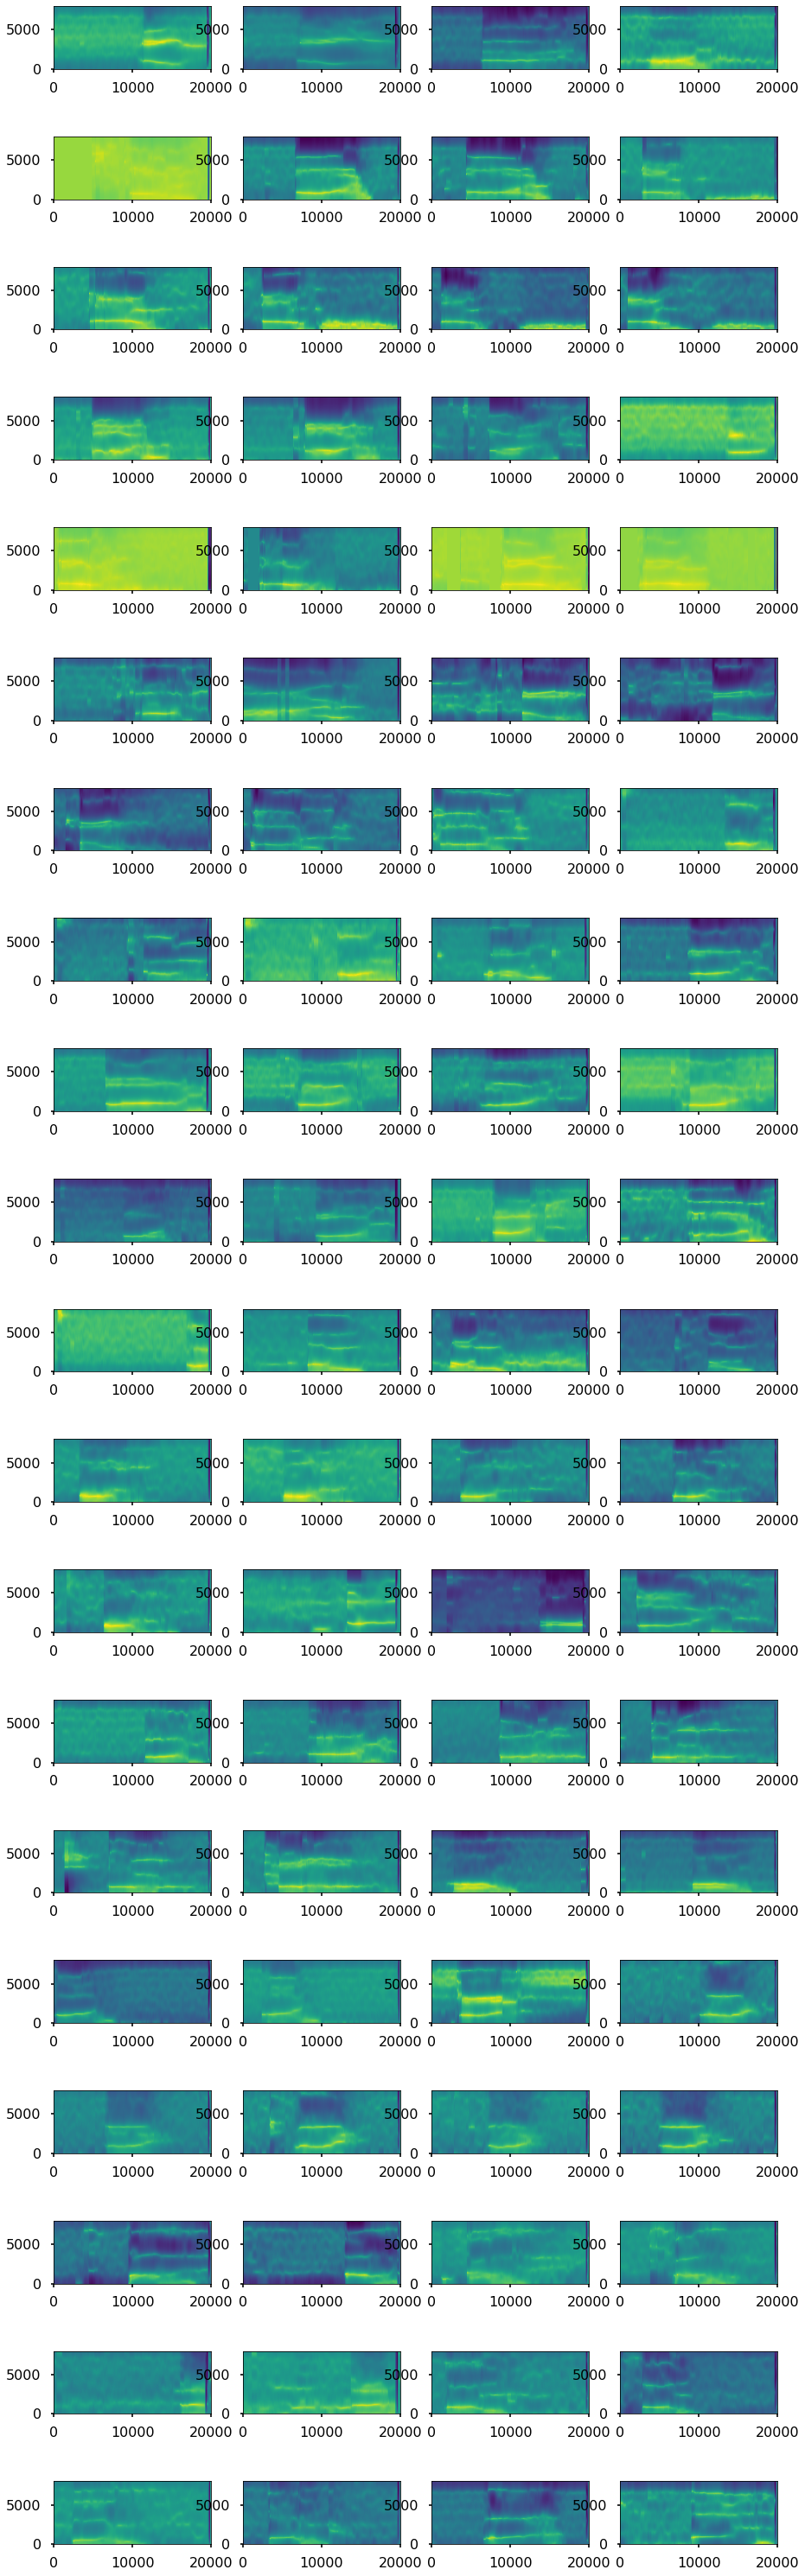

In [180]:
nrows = 20
ncols = 4
figure, ax = plt.subplots(nrows, ncols, figsize=(15, 55))

for i in tqdm(range(nrows), desc="Obtaining Formants..."):
    for j in range(ncols):
        curr_wav = wav_samples[ncols*i+j]
        curr_wav = read(curr_wav)[1]
        acoef_history, lpc_history, lpcf, lpc_diagram, wgdf_history, wgdf_diagram = lpc(pre_emphasize(curr_wav, 0.98), window_size=400, M=12, num_fft_points=256, pad=True)
        ax[i,j].imshow(lpc_diagram, extent=[0, 20000, 0, 8000])

160
160


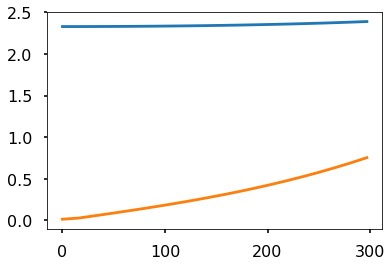

[ 937.5  3312.5  3593.75    0.      0.  ]


In [176]:
print(len(lpc_history))
print(len(wgdf_history))
sample = 100
x = lpc_history[sample]
wgdf = wgdf_history[sample]
plt.plot(lpcf[0:20]*sample_rate/(2*np.pi), x[0:20])
plt.plot(lpcf[0:20]*sample_rate/(2*np.pi), (np.gradient(x)*100)[0:20])
# plt.plot(lpcf[::4]*sample_rate/(2*np.pi), wgdf)
# plt.plot(lpcf[::4]*sample_rate/(2*np.pi), np.gradient(wgdf)*100)
plt.show()
print(formant_history.T[sample])

# Making Spectrograms

In [104]:
window_size = 80 # 80 samples per window. 16 kHz sample rate -> 5 ms window 
time_step = 16 # Move forward 16 samples per window.
num_padding = 400 # Amount to pad by, in number of samples. Total samples = num_padding + window_size
windows = []
spectrums = []

i = 0
while (i*time_step+window_size < len(curr_wav)):
    curr_window = curr_wav[i*time_step:i*time_step+window_size]
    if len(curr_window) != window_size: # pad the last few windows that are clipped at the end
        curr_window = np.concatenate([curr_window, np.array([0]*(window_size-len(curr_window)))])
    windows.append(curr_window)
    i += 1
        
for w in windows:
    window_kernel = np.hamming(window_size) # experiment with other kernels like Gaussian and Hann
    windowed = w * window_kernel
    padded = np.concatenate([windowed, np.array([0]*num_padding)])
    spectrum = abs(DFT(padded))
    spectrum = spectrum[0:len(spectrum)//2]
    spectrum = np.log(spectrum + 0.00001)
    spectrums.append(spectrum)
    
spectrums = np.vstack(spectrums)
spectrums = list(map(list, zip(*spectrums)))[::-1]

Text(0, 0.5, 'Hz')

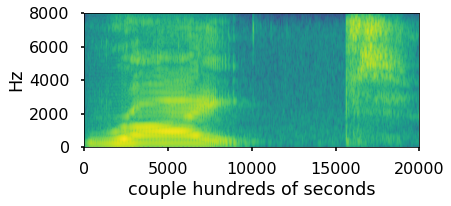

In [105]:
plt.imshow(spectrums, extent=[0, 20000, 0, 8000])
plt.xlabel("couple hundreds of seconds")
plt.ylabel("Hz")

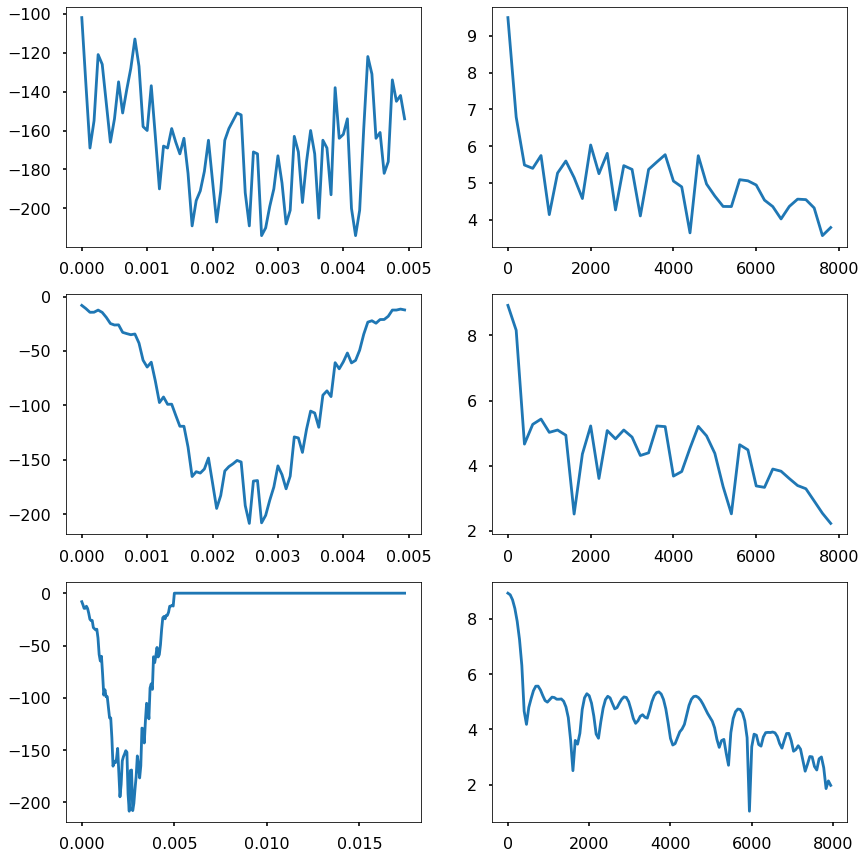

In [153]:
nrows = 3
ncols = 2
figure, ax = plt.subplots(nrows, ncols, figsize=(14,15))

# ----- Time domain of original window ----- #
sr = 16000 # 16 KHz
ts = 1.0/sr
t = np.arange(0,ts*window_size,ts)
x = windows[85]

ax[0,0].plot(t, x)

# ----- Freq. response of original window ----- #
X = DFT(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

ax[0,1].plot(freq[0:len(freq)//2], np.log(abs(X)[0:len(X)//2])) # // 2 to only plot below Nyquist

# ----- Time domain after windowing ----- #
x_windowed = x * np.hamming(80)
ax[1,0].plot(t, x_windowed)

# ----- Freq. response of windowed window ----- #
X_windowed = DFT(x_windowed)
ax[1,1].plot(freq[0:len(freq)//2], np.log(abs(X_windowed)[0:len(X_windowed)//2])) # // 2 to only plot below Nyquist

# ----- Zero-pad signal to increase freq. resolution ----- #
num_padding = 200
x_padded = np.concatenate([x_windowed, np.array([0]*num_padding)])
t_padded = np.arange(0, ts*(window_size+num_padding), ts)
ax[2,0].plot(t_padded, x_padded)

# ----- Freq. response of padded window ----- #
X_padded = DFT(x_padded)
N_padded = len(X_padded)
n_padded = np.arange(N_padded)
T_padded = N_padded/sr
freq_padded = n_padded/T_padded
ax[2,1].plot(freq_padded[0:len(freq_padded)//2], np.log(abs(X_padded)[0:len(X_padded)//2])) # // 2 to only plot below Nyquist